In [48]:
#############################################################setup_env########################################################################
import tweepy
from setup import get_creds
import pandas as pd
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

# secrets setup to retreive twitter api keys 
credentials = get_creds()
api_key = credentials["api_key"]
api_secret_key = credentials["api_key_secret"]
access_token = credentials["access_token"]
access_token_secret = credentials["access_token_secret"]
stopwords = stopwords.words("english")

In [49]:
#############################################################setup_twitter_and_test#############################################################

# Create The Authenticate Object
authenticate = tweepy.OAuthHandler(api_key, api_secret_key)

# Set The Access Token & Access Token Secret
authenticate.set_access_token(access_token, access_token_secret)

# Create The API Object and print tweets from Elon Musk
print("\n\nCreate The API Object and print tweets from Elon Musk\n")
api = tweepy.API(authenticate, wait_on_rate_limit = True)
tweets = api.user_timeline(screen_name = "elonmusk", count = 5, tweet_mode = "extended")
for tweet in tweets:
    print(f"- {tweet.full_text}")



Create The API Object and print tweets from Elon Musk

- @NewFolderF @dogeofficialceo @BillyM2k 🤣
- @BillyM2k Hamster has mad skillz!!
- @slashdot This is a serious concern.
- @SciGuySpace @Neopork85 @NASASpaceflight We aim to do the most for the least $
- Apologies, 10.2 release will be a week from Friday


In [50]:
#############################################################data_setup_and_cleaning#########################################################

# Create The API Object and retreive 200 tweets 
tweets = api.user_timeline(screen_name = "elonmusk", count = 200, tweet_mode = "extended")

#put tweet data into a pandas dataframe to work with  
df = pd.DataFrame([tweet.full_text for tweet in tweets], columns = ["tweet"])

# create function to clean the Data
def cleantext(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text) # Remove Mentions
    text = re.sub(r"#", "", text) # Remove Hashtags Symbol
    text = re.sub(r"RT[\s]+", "", text) # Remove Retweets
    text = re.sub(r"https?:\/\/\S+", "", text) # Remove The Hyper Link
    return text

# Clean The Text
df["tweet"] = df["tweet"].apply(cleantext)

#remove stopwords 
df["tweet"] =  df["tweet"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [51]:
#############################################################nlp_and_sentiment_analysis######################################################

#show top 20 most frequently used words
word_count = Counter(" ".join(df['tweet']).split()).most_common(10)
word_frequency = pd.DataFrame(word_count, columns = ['Word', 'Frequency'])
print(word_frequency)

# Get The Subjectivity
    # The polarity is a value ranging between -1 and 1, with -1 being very negative and +1 very positive. 
    # The subjectivity ranges between 0 and 1, and refers to the person’s opinion, emotion, or even judgment. 
    # The higher the number, the more subjective the text is.
def sentiment_analysis(ds):
    sentiment = TextBlob(ds["tweet"]).sentiment
    return pd.Series([sentiment.subjectivity, sentiment.polarity])

# Adding Subjectivity & Polarity
df[["subjectivity", "polarity"]] = df.apply(sentiment_analysis, axis=1)
#print(df)


def analysis_definition(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"
    
# Create a New Analysis Column and add to sentiment dataframe created in sentiment analysis  
df["analysis"] = df["polarity"].apply(analysis_definition)
# Print The Data
print(df)

# If twitter API won't return consistent results you can use the csv in the project for plotting and analysis 
#df = pd.read_csv("200_tweets.csv")

#Explore what positive and negative tweets look like 
positive_tweets = df[df['analysis'] == 'Positive']
negative_tweets = df[df['analysis'] == 'Negative']


print('\n positive tweets')
for i, row in positive_tweets[:10].iterrows():
  print(' -' + row['tweet'])

print('\n negative tweets')
for i, row in negative_tweets[:10].iterrows():
  print(' -' + row['tweet'])


    Word  Frequency
0  &amp;         24
1      :         18
2  Tesla         15
3    FSD         10
4   crew          8
5   beta          7
6     It          7
7    The          7
8   cars          6
9      _          6
                                   tweet  subjectivity  polarity  analysis
0                                      🤣      0.000000  0.000000   Neutral
1                   Hamster mad skillz!!      1.000000 -0.976562  Negative
2                  This serious concern.      0.666667 -0.333333  Negative
3                         We aim least $      0.400000 -0.300000  Negative
4    Apologies, 10.2 release week Friday      0.000000  0.000000   Neutral
..                                   ...           ...       ...       ...
195                                           0.000000  0.000000   Neutral
196               Cybertruck like others      0.000000  0.000000   Neutral
197                      That sums well!      0.000000  0.000000   Neutral
198                           


 Since the ratio of positive to negative tweets is 4.222222222222222, we can conclude Elon Musk's tweets are primarily positive


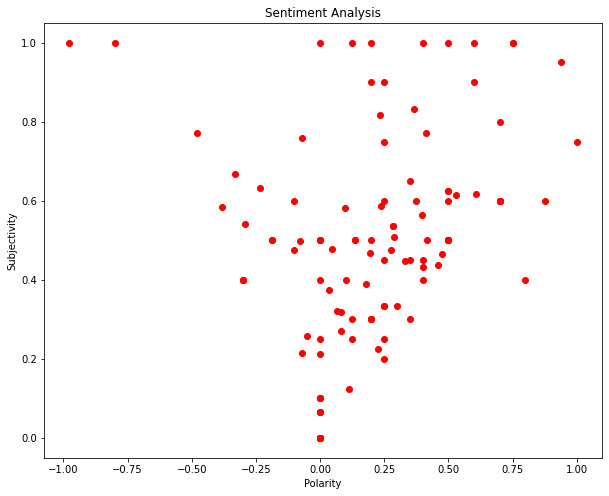

In [52]:
#############################################################analyze_findings###############################################################


sentiment_ratio =  len(positive_tweets) / len(negative_tweets)
print(f"\n Since the ratio of positive to negative tweets is {sentiment_ratio}, we can conclude Elon Musk's tweets are primarily positive")

#plot negative and positive tweets 
plt.figure(figsize=(10, 8))

for i in range(0, df.shape[0]):
    plt.scatter(df["polarity"][i], df["subjectivity"][i], color = "Red")

plt.title("Sentiment Analysis") # Add The Graph Title
plt.xlabel("Polarity") # Add The X-Label
plt.ylabel("Subjectivity") # Add The Y-Label
plt.show() # Showing The Graph
